In [30]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/PlantVillage_data"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

In [3]:
full_dataset = image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode= "categorical",
    color_mode='rgb',
    shuffle=True
)

Found 20360 files belonging to 26 classes.


In [4]:
class_names = full_dataset.class_names
class_names

['Chili__healthy',
 'Chili__leaf curl',
 'Chili__leaf spot',
 'Chili__whitefly',
 'Chili__yellowish',
 'Cotton_Disease',
 'Cotton_Healthy',
 'Mango__diseased',
 'Mango__healthy',
 'Potato__early_blight',
 'Potato__healthy',
 'Potato__late_blight',
 'Rice__brown_spot',
 'Rice__healthy',
 'Rice__hispa',
 'Rice__leaf_blast',
 'Rice__neck_blast',
 'Tomato__bacterial_spot',
 'Tomato__healthy',
 'Tomato__leaf_mold',
 'Tomato__mosaic_virus',
 'Tomato__yellow_leaf_curl_virus',
 'Wheat__brown_rust',
 'Wheat__healthy',
 'Wheat__septoria',
 'Wheat__yellow_rust']

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np


dataset_path = '/content/drive/MyDrive/Colab Notebooks/PlantVillage_data'


class_counts = {}


for class_name in sorted(os.listdir(dataset_path)):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        image_files = [f for f in os.listdir(class_folder)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(image_files)


print(" Number of images per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} images")


 Number of images per class:
  Chili__healthy: 100 images
  Chili__leaf curl: 100 images
  Chili__leaf spot: 100 images
  Chili__whitefly: 100 images
  Chili__yellowish: 100 images
  Cotton_Disease: 98 images
  Cotton_Healthy: 453 images
  Mango__diseased: 265 images
  Mango__healthy: 170 images
  Potato__early_blight: 1096 images
  Potato__healthy: 152 images
  Potato__late_blight: 1093 images
  Rice__brown_spot: 653 images
  Rice__healthy: 1488 images
  Rice__hispa: 565 images
  Rice__leaf_blast: 981 images
  Rice__neck_blast: 1000 images
  Tomato__bacterial_spot: 2136 images
  Tomato__healthy: 1598 images
  Tomato__leaf_mold: 957 images
  Tomato__mosaic_virus: 382 images
  Tomato__yellow_leaf_curl_virus: 3214 images
  Wheat__brown_rust: 915 images
  Wheat__healthy: 1225 images
  Wheat__septoria: 97 images
  Wheat__yellow_rust: 1132 images


In [6]:
import os

dataset_path = '/content/drive/MyDrive/Colab Notebooks/PlantVillage_data'


class_labels = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

print("Class labels:")
for i, label in enumerate(class_labels):
    print(f"{i}: {label}")


Class labels:
0: Chili__healthy
1: Chili__leaf curl
2: Chili__leaf spot
3: Chili__whitefly
4: Chili__yellowish
5: Cotton_Disease
6: Cotton_Healthy
7: Mango__diseased
8: Mango__healthy
9: Potato__early_blight
10: Potato__healthy
11: Potato__late_blight
12: Rice__brown_spot
13: Rice__healthy
14: Rice__hispa
15: Rice__leaf_blast
16: Rice__neck_blast
17: Tomato__bacterial_spot
18: Tomato__healthy
19: Tomato__leaf_mold
20: Tomato__mosaic_virus
21: Tomato__yellow_leaf_curl_virus
22: Wheat__brown_rust
23: Wheat__healthy
24: Wheat__septoria
25: Wheat__yellow_rust


In [7]:
total_batches = tf.data.experimental.cardinality(full_dataset).numpy()
print(total_batches)
train_size = int(0.75 * total_batches)
val_test_size = int(0.15 * total_batches)
test_size = total_batches - train_size - val_test_size
print(train_size, val_test_size, test_size)

637
477 95 65


In [8]:
train_ds = full_dataset.take(train_size)
val_ds = full_dataset.skip(train_size).take(val_test_size)
test_ds = full_dataset.skip(train_size + val_test_size)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False


inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

from tensorflow.keras.models import Model
model = Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │        33,306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,291,290 (8.74 MB)

 Trainable params: 33,306 (130.10 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
EPOCHS = 15
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)


Epoch 1/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 1599s 3s/step - accuracy: 0.8567 - loss: 0.4411 - val_accuracy: 0.9148 - val_loss: 0.2513
Epoch 2/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 1167s 2s/step - accuracy: 0.9123 - loss: 0.2630 - val_accuracy: 0.9250 - val_loss: 0.2132
Epoch 3/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 1131s 2s/step - accuracy: 0.9234 - loss: 0.2161 - val_accuracy: 0.9260 - val_loss: 0.2014
Epoch 4/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 1193s 2s/step - accuracy: 0.9372 - loss: 0.1902 - val_accuracy: 0.9306 - val_loss: 0.1955
Epoch 5/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 1133s 2s/step - accuracy: 0.9358 - loss: 0.1726 - val_accuracy: 0.9303 - val_loss: 0.1879
Epoch 6/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 1140s 2s/step - accuracy: 0.9427 - loss: 0.1606 - val_accuracy: 0.9378 - val_loss: 0.1681
Epoch 7/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 1167s 2s/step - accuracy: 0.9470 - loss: 0.1481 - val_accuracy: 0.9342 - val_loss: 0.1743
Epoch 8/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 1174s 2s/step - accuracy: 0.9486 - loss: 0.1432 - 

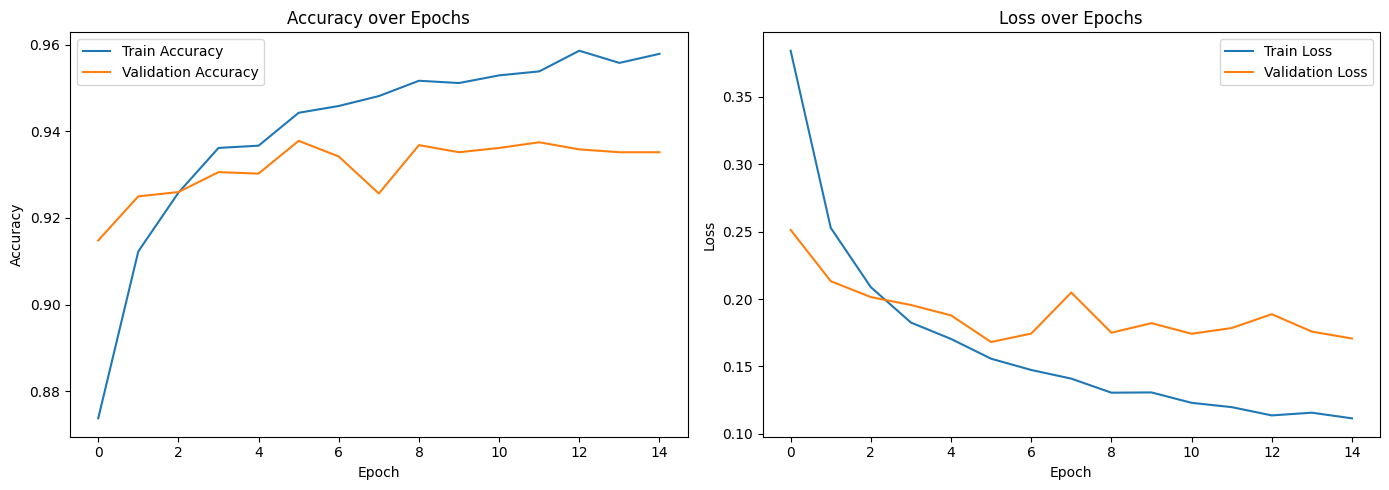

In [20]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

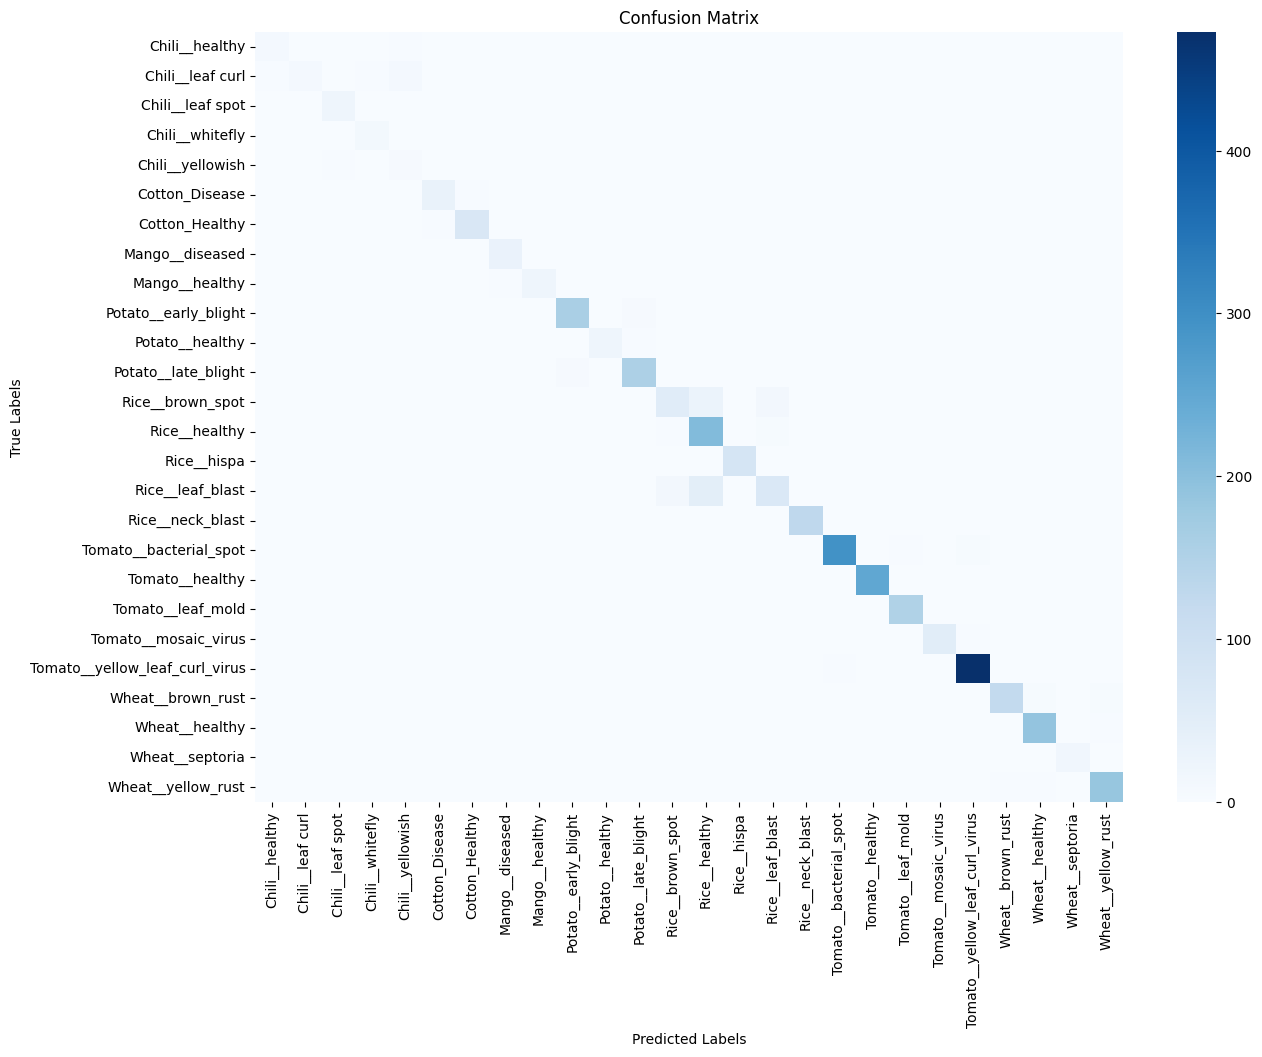

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    # Convert one-hot encoded labels to integer labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [25]:
model.save('/content/drive/MyDrive/PlantDisease_MobilenetV2_model.keras')

In [26]:
from google.colab import files


files.download("/content/drive/MyDrive/PlantDisease_MobilenetV2_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>